In [284]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error


In [349]:
# Copy the dataset
df = pd.read_csv("Food_Delivery_Times(2).csv")

In [351]:
df.head() 

,Order_ID,delivery_distance_km,Weather_Condition,Traffic_Conditions,Order_Time,Vehicle_Type,Order_Size,Courier_Experience_yrs,Delivery_Time
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


In [353]:
df.isnull().sum()

Order_ID                   0
delivery_distance_km       0
Weather_Condition         30
Traffic_Conditions        30
Order_Time                30
Vehicle_Type               0
Order_Size                 0
Courier_Experience_yrs    30
Delivery_Time              0
dtype: int64

In [355]:
df = df.dropna()

In [357]:
df.describe().head()

,Order_ID,delivery_distance_km,Order_Size,Courier_Experience_yrs,Delivery_Time
count,883.000000,883.000000,883.000000,883.000000,883.000000
mean,508.109853,10.051586,17.019253,4.639864,56.425821
std,287.925161,5.688582,7.260201,2.922172,21.568482
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,263.500000,5.130000,11.000000,2.000000,41.000000


In [359]:
df.columns = [col.strip().replace(" ", "_").lower() for col in df.columns]

In [361]:
print(df.columns)

Index(['order_id', 'delivery_distance_km', 'weather_condition',
       'traffic_conditions', 'order_time', 'vehicle_type', 'order_size',
       'courier_experience_yrs', 'delivery_time'],
      dtype='object')


In [363]:
import pandas as pd
import requests
from sklearn.preprocessing import LabelEncoder

In [365]:
# Example: Mock coordinates and timestamp for testing
df['Latitude'] = 28.6139  # New Delhi example
df['Longitude'] = 77.2090
df['Order_Timestamp'] = pd.to_datetime('2024-04-20 14:00:00')  # Replace with real timestamps

In [367]:
# --- Function to get weather from OpenWeatherMap API ---
def get_weather(lat, lon, timestamp, api_key='your_openweathermap_api_key'):
    unix_time = int(pd.Timestamp(timestamp).timestamp())
    url = "https://api.openweathermap.org/data/2.5/onecall/timemachine"
    params = {
        'lat': lat,
        'lon': lon,
        'dt': unix_time,
        'appid': api_key,
        'units': 'metric'
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        weather_data = response.json()
        return weather_data['current']['weather'][0]['main']
    else:
        print(f"Failed to fetch weather: {response.status_code}")
        return 'Unknown'

# Apply the API call to a subset (to avoid limits)
#df['Weather_API'] = df.apply(lambda row: get_weather(row['Latitude'], row['Longitude'], row['Order_Timestamp']), axis=1)



In [373]:
# --- Encode categorical variables ---
categorical_cols = ['weather_condition', 'traffic_conditions', 'order_time', 'vehicle_type']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_Encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

print(df.head())

   order_id  delivery_distance_km weather_condition traffic_conditions  \
0       522                  7.93             Windy                Low   
1       738                 16.42             Clear             Medium   
2       741                  9.52             Foggy                Low   
3       661                  7.44             Rainy             Medium   
4       412                 19.03             Clear                Low   

  order_time vehicle_type  order_size  courier_experience_yrs  delivery_time  \
0  Afternoon      Scooter          12                     1.0             43   
1    Evening         Bike          20                     2.0             84   
2      Night      Scooter          28                     1.0             59   
3  Afternoon      Scooter           5                     1.0             37   
4    Morning         Bike          16                     5.0             68   

   Latitude  Longitude     Order_Timestamp  weather_condition_Encoded  \
0

### Exploratory Data Analysis (EDA):

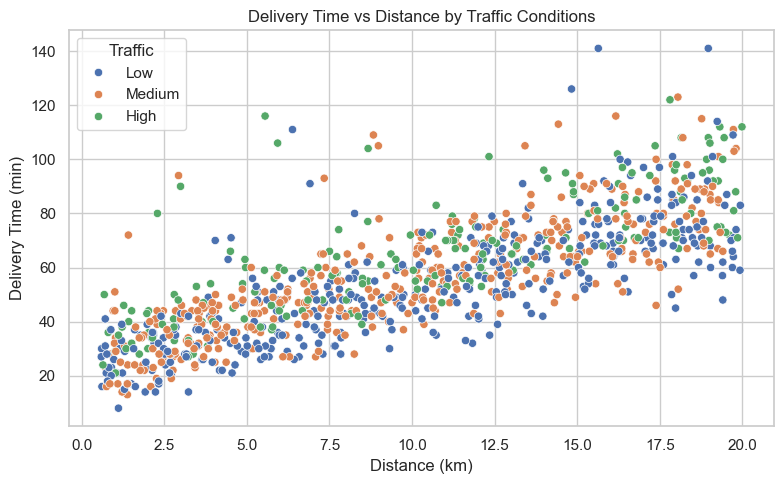

In [381]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset again for clean EDA
df = pd.read_csv("Food_Delivery_Times(2).csv")

# Set Seaborn style
sns.set(style="whitegrid")

# --- 1. Distance vs Delivery Time ---
plt.figure(figsize=(8, 5))
sns.scatterplot(x='delivery_distance_km', y='Delivery_Time', hue='Traffic_Conditions', data=df)
plt.title("Delivery Time vs Distance by Traffic Conditions")
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (min)")
plt.legend(title="Traffic")
plt.tight_layout()
plt.show()



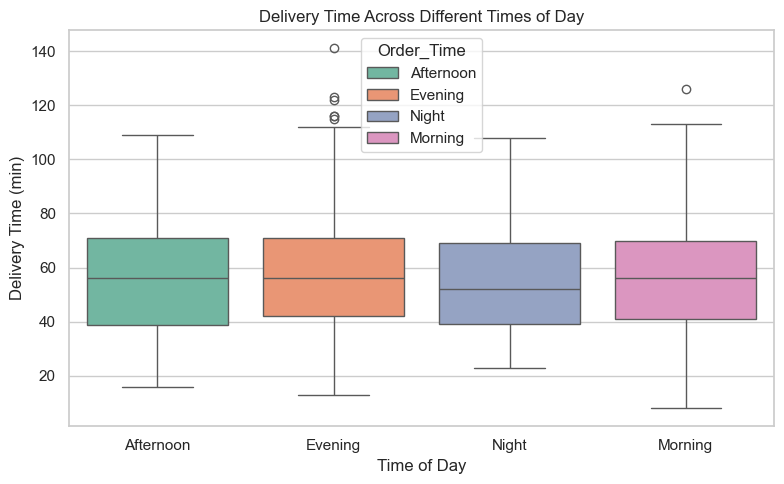

In [391]:
# --- 2. Time of Day vs Delivery Time ---
plt.figure(figsize=(8, 5))
sns.boxplot(x='Order_Time', y='Delivery_Time', hue= 'Order_Time', data=df, palette="Set2")
plt.title("Delivery Time Across Different Times of Day")
plt.xlabel("Time of Day")
plt.ylabel("Delivery Time (min)")
plt.tight_layout()
plt.show()



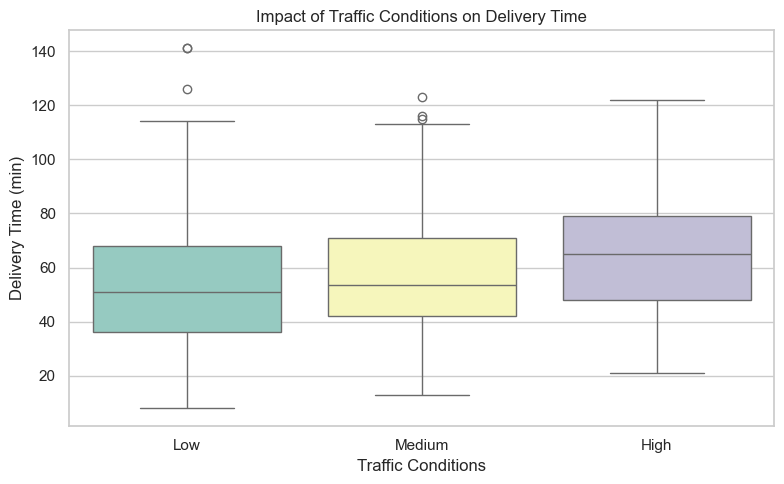

In [389]:
# --- 3. Traffic Conditions vs Delivery Time ---
plt.figure(figsize=(8, 5))
sns.boxplot(x='Traffic_Conditions', y='Delivery_Time', hue='Traffic_Conditions', data=df, palette="Set3", legend=False)
plt.title("Impact of Traffic Conditions on Delivery Time")
plt.xlabel("Traffic Conditions")
plt.ylabel("Delivery Time (min)")
plt.tight_layout()
plt.show()


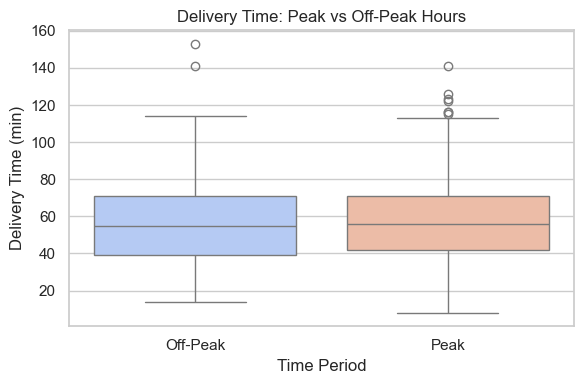

In [393]:
# --- 4. Peak-hour vs Off-peak Analysis ---
# Define peak hours as: Morning, Evening | Off-peak as: Afternoon, Night
df['Peak_Offpeak'] = df['Order_Time'].apply(lambda x: 'Peak' if x in ['Morning', 'Evening'] else 'Off-Peak')

plt.figure(figsize=(6, 4))
sns.boxplot(x='Peak_Offpeak', y='Delivery_Time',hue='Peak_Offpeak', data=df, palette="coolwarm")
plt.title("Delivery Time: Peak vs Off-Peak Hours")
plt.xlabel("Time Period")
plt.ylabel("Delivery Time (min)")
plt.tight_layout()
plt.show()

#### Analyze peak-hour vs. off-peak delivery times.

In [395]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop missing values for required columns
df = df.dropna(subset=['Order_Time', 'Delivery_Time'])

# Map Order_Time to numeric hour
time_map = {
    'Morning': 9,
    'Afternoon': 14,
    'Evening': 19,
    'Night': 22
}
df['Order_Hour'] = df['Order_Time'].map(time_map)

# Classify peak vs off-peak
def classify_time_period(hour):
    if 11 <= hour <= 14 or 18 <= hour <= 21:
        return 'Peak'
    else:
        return 'Off-Peak'

df['Time_Period'] = df['Order_Hour'].apply(classify_time_period)

# Group by Time_Period to get summary stats
summary_stats = df.groupby('Time_Period')['Delivery_Time'].agg(['mean', 'median', 'count']).reset_index()

summary_stats

,Time_Period,mean,median,count
0,Off-Peak,55.923664,55.0,393
1,Peak,56.792028,56.0,577


### Model Selection and Training:

In [397]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [399]:
# --- Encode categorical features ---
categorical_cols = ['Weather_Condition', 'Traffic_Conditions', 'Order_Time', 'Vehicle_Type']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [401]:
# --- Feature and target selection ---
features = ['delivery_distance_km', 'Weather_Condition', 'Traffic_Conditions', 'Order_Time', 'Vehicle_Type']
target = 'Delivery_Time'

X = df[features]
y = df[target]


In [403]:
# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [405]:
# --- Initialize models ---
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


In [407]:
# --- Train, Predict, and Evaluate ---
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = mae

results

{'Decision Tree': 13.639175257731958,
 'Random Forest': 10.704720790378007,
 'Gradient Boosting': 10.372626959597516}

#### Evaluate accuracy using Mean Absolute Error (MAE).

In [422]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your dataset
df = pd.read_csv("Food_Delivery_Times(2).csv")

# Drop rows with missing Order_Time or Delivery_Time
df = df.dropna(subset=['Order_Time', 'Delivery_Time'])

# Step 1: Map Order_Time to approximate hour
time_map = {
    'Morning': 9,
    'Afternoon': 14,
    'Evening': 19,
    'Night': 22
}
df['Order_Hour'] = df['Order_Time'].map(time_map)

# Step 2: Classify Peak vs Off-Peak
def get_time_period(hour):
    if 11 <= hour <= 14 or 18 <= hour <= 21:
        return 'Peak'
    else:
        return 'Off-Peak'

df['Time_Period'] = df['Order_Hour'].apply(get_time_period)

# Step 3: Encode categorical variables
df = pd.get_dummies(df, columns=['Weather_Condition', 'Traffic_Conditions', 'Vehicle_Type', 'Time_Period'], drop_first=True)

# Step 4: Define features and target
X = df.drop(columns=['Order_ID', 'Order_Time', 'Delivery_Time'])  # Exclude irrelevant columns
y = df['Delivery_Time']

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Scale numeric features (if necessary)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Train Random Forest Model
model = RandomForestRegressor(random_state=42)
model.fit(X_train_scaled, y_train)

# Step 8: Predict and Calculate MAE
y_pred = model.predict(X_test_scaled)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"📏 Mean Absolute Error (MAE): {mae:.2f} minutes")


📏 Mean Absolute Error (MAE): 7.94 minutes


In [ ]:
import pickle
pickle.dump(model, open('delivery_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))


In [424]:
import pickle

# Assume X_train is your final DataFrame used for model training
pickle.dump(X_train.columns.tolist(), open('feature_columns.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(model, open('delivery_model.pkl', 'wb'))
